```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

Run deterministic forecast for comparison with OpenDrift and NorKyst.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset

#Helpful during development
import importlib
#importlib.reload(module)

import datetime

from IPython.display import display

import matplotlib

from matplotlib import pyplot as plt
#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 100.0 #highres movies/plots

plt.rcParams["animation.writer"] = 'ffmpeg' 
plt.rcParams["animation.codec"] = 'h264' 

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

from SWESimulators import CDKLM16, Common, IPythonMagic, NetCDFInitialization
from SWESimulators import GPUDrifterCollection, Observation
from SWESimulators import DataAssimilationUtils as dautils

from demos.realisticSimulations import norkyst_plotting

In [4]:
%cuda_context_handler gpu_ctx

# Analyse a given DA experiment

In [63]:
result_folder, description = 'EPS_30821_2019_12_05-21_42_22/', '48 hours DA, resampling every 5 min'


In [62]:
def analyse_resampling(result_folder, description):

    resampling_folder = os.path.join(result_folder, 'resampling')
    resampling_files = os.listdir(resampling_folder)

    num_resampling_steps = len(resampling_files)
    
    # Print some info about the first iteration
    print('Analysing: ' + description)
    print('------------------')
    print('num_resampling_steps: ', num_resampling_steps)

    print('Info about the first iteration:')
    weight, resample_ids = np.load(os.path.join(resampling_folder, resampling_files[0]))
    print('First resampling step')
    print('max weight', weight.max())
    print('particles with w > 1%: ', np.count_nonzero(weight > 0.001))
    print('weights > 1%: ', weight[weight > 0.01], weight[weight > 0.001].sum())
    print('num_resampled_particles: ', len(np.unique(resample_ids)))
    
    # Crunch the numbers
    num_resampled_particles = np.zeros(num_resampling_steps)
    weight_max = np.zeros(num_resampling_steps)
    particles_with_weight_more_than_one = np.zeros(num_resampling_steps)

    for i in range(num_resampling_steps):
        weight, resample_ids = np.load(os.path.join(resampling_folder, resampling_files[i]))

        num_resampled_particles[i] = len(np.unique(resample_ids))
        weight_max[i] = weight.max()
        particles_with_weight_more_than_one[i] = np.count_nonzero(weight > 0.01)

    # Print some worst case scenarios:
    print('---------------')
    print('Some worst case scenarios:')
    print('weight_max.min(), weight_max.max(), weight_max.argmax():', weight_max.min(), weight_max.max(), weight_max.argmax())
    print('Number of times the max weight is over 50%: ', np.count_nonzero(weight_max > 0.5))
    print('Iterations and max weigths when the max weight is over 50%:')
    for i in range(num_resampling_steps):
        if (weight_max[i] > 0.5):
            print(i, weight_max[i])
    
    fig = plt.figure(figsize=(15,4))
    plt.plot(num_resampled_particles)
    plt.grid()
    plt.xlabel('Resampling step')
    plt.ylabel('Num resampled particles')
    plt.title(description)
    
    fig = plt.figure(figsize=(15,4))
    plt.plot(weight_max)
    plt.grid()
    plt.xlabel('Resampling step')
    plt.ylabel('Max weight')
    plt.title(description)
    
    fig = plt.figure(figsize=(15,4))
    plt.plot(particles_with_weight_more_than_one)
    plt.grid()
    plt.xlabel('Resampling step')
    plt.ylabel('Particles with w > 1%')
    plt.title(description)

Analysing: 48 hours DA, resampling every 5 min
------------------
num_resampling_steps:  576
Info about the first iteration:
First resampling step
max weight 0.22230722299593236
particles with w > 1%:  80
weights > 1%:  [0.08712753 0.0122069  0.04941752 0.06119526 0.22230722 0.12320515
 0.01049516 0.01896189 0.09939491] 0.9257617724968663
num_resampled_particles:  144
---------------
Some worst case scenarios:
weight_max.min(), weight_max.max(), weight_max.argmax(): 0.007511401572021662 0.9999293677947829 375
Number of times the max weight is over 50%:  6
Iterations and max weigths when the max weight is over 50%:
70 0.8179203766568054
78 0.8692581696099027
188 0.8563480196703869
288 0.5083947482263749
360 0.5418267482344533
375 0.9999293677947829


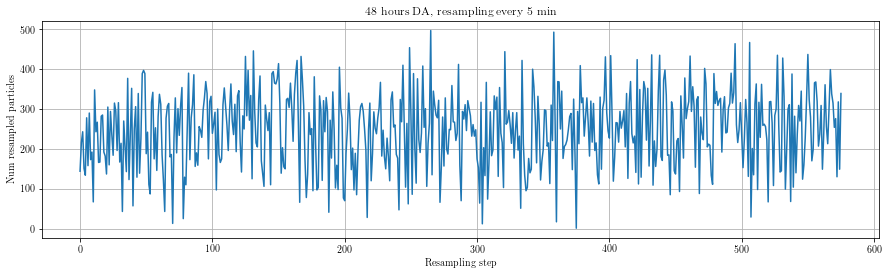

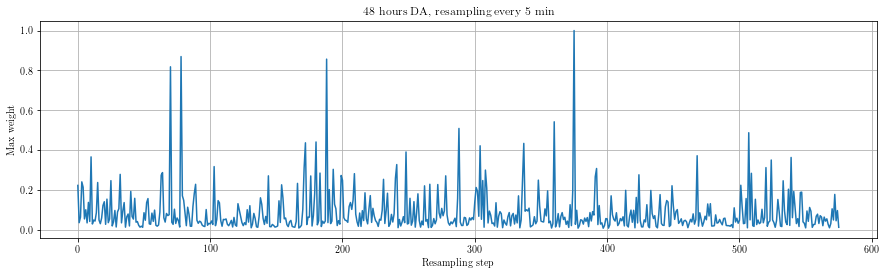

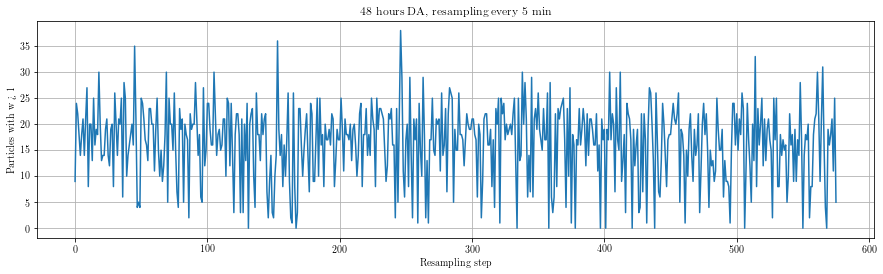

In [64]:
analyse_resampling(result_folder, description)